1. train : 학습용 데이터셋

	├ 10001 : 데이터 고유 아이디

	│	├ 10001.jpg : 이미지 파일

	│	├ 10001.csv : 환경 데이터

	│		└ 촬영 전 48 시간의 "측정 시각", "내부 온도", "내부 습도", "내부 이슬점", "내부 CO2", "외부 풍속", "외부 누적일사" 등의 환경 정보

	│	└ 10001.json :

	│		├ description 

	│		│	├ image : 이미지 파일 이름

	│		│	├ date : 촬영 날짜

	│		│	├ time : 촬영 시간

	│		│	├ region : 촬영 지역

	│		│	├ height : 이미지 높이

	│		│	├ width : 이미지 너비

	│		│	└  task : 데이터 종류 (질병/해충/병해/정상 구분)

	│		└ annotations

	│				├ disease : 작물 상태 코드

	│				├ crop : 작물 코드

	│				├ area : 작물 촬영 부위

	│				├ grow : 작물의 생육 단계 

	│				├ risk : 질병 피해 정도

	│				├ bbox : 주목 객체 바운딩 박스 (x, y, w, h 형태)

	│				└ part : 병해 부위 바운딩 박스 (x, y, w, h 형태)

	│

	├ 10002

	├ 10003

	└ ...

	[추가] train.csv : train set에 대한 정답 파일

 image : 이미지 파일 이름
 label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열
 "{crop}_{disease}_{risk}"




2. test : 평가용 데이터셋

	├ 10001 : 데이터 고유 아이디

	│	├ 10001.csv : 환경 데이터

	│		└ 촬영 전 48 시간의 "측정 시각", "내부 온도", "내부 습도", "내부 이슬점", "내부 CO2", "외부 풍속", "외부 누적일사" 등의 환경 정보

	│	└ 10001.jpg : 이미지 파일

	│

	├ 10002

	├ 10003

	└ ...



3. sample_submission.csv : 제출용 양식

 image : 이미지 파일 이름
 label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열
 "{crop}_{disease}_{risk}"

\

```
- 모델목표 :  label : "{작물 코드}_{작물 상태 코드}_{질병 피해 정도}" 형태의 문자열 "{crop}_{disease}_{risk}"
- "작물 환경 데이터"와 "작물 병해 이미지"를 이용해 crop_disease_risk 예측 

```



# 모듈 

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# 패키지

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score

# 데이터 로드 

In [3]:
!cp /content/drive/MyDrive/DataSet/data.zip ./

In [4]:
!unzip ../content/data.zip

Archive:  ../content/data.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.csv               
  inflating: train.zip               


In [ ]:
!unzip ../content/train.zip

# 데이터 살펴보기

In [6]:
listdir = list(os.listdir('/content/train'))

In [ ]:
sample = listdir[21]

sample_csv = pd.read_csv(f'/content/train/{sample}/{sample}.csv')
sample_image = cv2.imread(f'/content/train/{sample}/{sample}.jpg')
sample_json = json.load(open(f'/content/train/{sample}/{sample}.json', 'r'))

In [ ]:
sample_csv.head()

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,내부 온도 4 평균,내부 온도 4 최고,내부 온도 4 최저,내부 습도 1 평균,내부 습도 1 최고,내부 습도 1 최저,내부 습도 2 평균,내부 습도 2 최고,내부 습도 2 최저,내부 습도 3 평균,내부 습도 3 최고,내부 습도 3 최저,내부 습도 4 평균,내부 습도 4 최고,내부 습도 4 최저,내부 이슬점 평균,내부 이슬점 최고,내부 이슬점 최저,내부 CO2 평균,내부 CO2 최고,내부 CO2 최저,외부 풍속 평균,외부 풍속 최고,외부 풍속 최저,내부 EC 1 평균,내부 EC 1 최고,내부 EC 1 최저,내부 PH 1 평균,내부 PH 1 최고,내부 PH 1 최저,배지 중량 평균,배지 중량 최고,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-08-17 12:00:00,33.8,34.7,32.9,-,-,-,-,-,-,-,-,-,57.4,59.8,53.0,-,-,-,-,-,-,-,-,-,24.3,25.1,23.9,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,949.2,-,-
1,2021-08-17 11:50:00,32.9,33.5,32.5,-,-,-,-,-,-,-,-,-,57.6,61.4,54.8,-,-,-,-,-,-,-,-,-,23.6,24.5,22.8,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,386.3,-,-
2,2021-08-17 11:40:00,33.0,33.6,32.1,-,-,-,-,-,-,-,-,-,61.0,65.6,55.5,-,-,-,-,-,-,-,-,-,24.6,25.7,23.1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,811.4,-,-
3,2021-08-17 11:30:00,30.8,31.8,30.4,-,-,-,-,-,-,-,-,-,65.4,69.2,63.3,-,-,-,-,-,-,-,-,-,23.5,24.6,22.5,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,689.4,-,-
4,2021-08-17 11:20:00,29.9,30.5,29.4,-,-,-,-,-,-,-,-,-,67.6,70.9,66.2,-,-,-,-,-,-,-,-,-,23.4,24.2,23.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,540.8,-,-


In [ ]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# json
sample_json

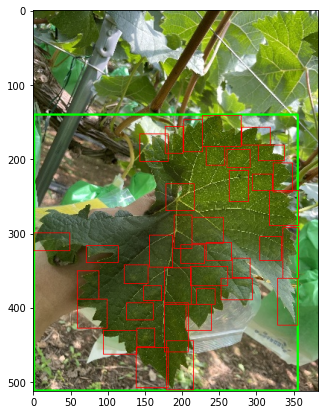

In [ ]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(#<---- 잎파리 박스 
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points: #<---- 병충 라벨링
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# 환경통계량  scaling 용 min - max 

In [ ]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'] 

In [ ]:
csv = listdir[1]
temp_csv = pd.read_csv(f'/content/train/{csv}/{csv}.csv')[csv_features]

In [ ]:
temp_csv = np.array(temp_csv)
temp_csv[temp_csv=='-']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [ ]:
x = temp_csv.shape[0]
y = temp_csv.shape[1]

In [ ]:
print(np.max(temp_csv.reshape(x*y).astype(float)),np.min(temp_csv.reshape(x*y).astype(float)))

97.2 14.1


In [ ]:
csv = listdir[0]
temp_csv = pd.read_csv(f'/content/train/{csv}/{csv}.csv')[csv_features]
temp_csv = np.array(temp_csv)
temp_csv[temp_csv=='-']=0
x = temp_csv.shape[0]
y = temp_csv.shape[1]
temp_csv = temp_csv.reshape(x*y).astype(float)
temp_csv = temp_csv.reshape(x,y)
max_arr = np.max(temp_csv,axis=0)
min_arr = np.min(temp_csv,axis=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


In [ ]:
min_arr

array([19.7, 19.7, 19.6, 49.3, 50.1, 48.3, 18.4, 18.5, 18.3])

In [ ]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']


n=0
# feature 별 최대값, 최솟값 계산
for csv in listdir[1:]:
    temp_csv = pd.read_csv(f'/content/train/{csv}/{csv}.csv')[csv_features]
    temp_csv = np.array(temp_csv)
    temp_csv[temp_csv=='-']=0
    x = temp_csv.shape[0]
    y = temp_csv.shape[1]
    temp_csv = temp_csv.reshape(x*y).astype(float)
    temp_csv = temp_csv.reshape(x,y)
    temp_max = np.max(temp_csv,axis=0)
    temp_min = np.min(temp_csv,axis=0)
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
print(min_arr)
print(max_arr)

[3.4 3.4 3.3 0.  0.  0.  0.  0.  0. ]
[ 47.3  47.6  47.  100.  100.  100.   34.5  34.7  34.4]


In [ ]:
# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

{'내부 습도 1 최고': [0.0, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 습도 1 평균': [0.0, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.0, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.0, 34.5]}

# 라벨링 확인 
- "{작물 코드}{작물 상태 코드}{질병 피해 정도}" 형태의 문자열 "{crop}{disease}{risk}

In [ ]:
label = pd.read_csv('train.csv')

In [ ]:
label

,image,label
0,10027,3_b7_1
1,10037,3_00_0
2,10043,3_00_0
3,10045,3_00_0
4,10063,3_00_0
...,...,...
5762,67640,3_00_0
5763,67644,1_00_0
5764,67647,2_a5_2
5765,67649,1_00_0


In [ ]:
label['crop'] = label['label'].apply(lambda x : x[:1])

In [ ]:
label['disease'] = label['label'].apply(lambda x : x[2:4])

In [ ]:
label['risk']=label['label'].apply(lambda x : x[-1])

In [ ]:
label.head() #<---- 이게 예측해야 하는 y 값 

,image,label,crop,disease,risk
0,10027,3_b7_1,3,b7,1
1,10037,3_00_0,3,00,0
2,10043,3_00_0,3,00,0
3,10045,3_00_0,3,00,0
4,10063,3_00_0,3,00,0


작물 종류

In [ ]:
temp = np.array(label['crop']).astype(np.int)

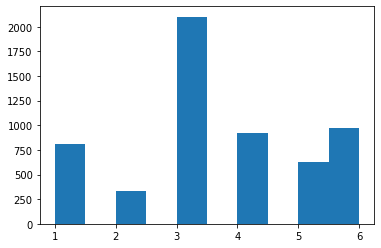

In [ ]:
plt.hist(temp)
plt.show()

작물상태코드

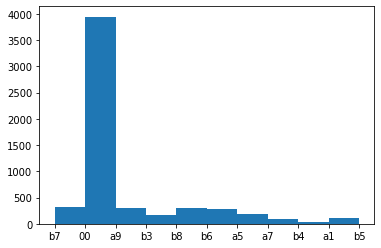

In [ ]:
plt.hist(label['disease'])
plt.show()

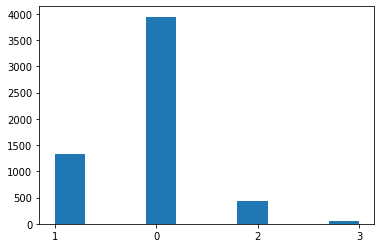

In [ ]:
plt.hist(label['risk'])
plt.show()  

## 라벨 별 분포 확인 

In [ ]:
label.head()

,image,label,crop,disease,risk
0,10027,3_b7_1,3,b7,1
1,10037,3_00_0,3,00,0
2,10043,3_00_0,3,00,0
3,10045,3_00_0,3,00,0
4,10063,3_00_0,3,00,0


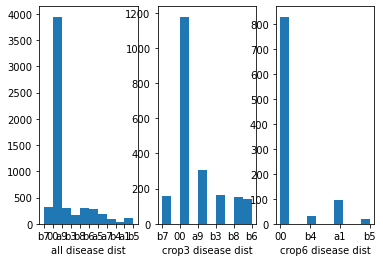

In [ ]:
plt.subplot(1,3,1)
plt.hist(label['disease'])
plt.xlabel('all disease dist')
plt.subplot(1,3,2)
plt.hist(label[label['crop']== '3']['disease'])
plt.xlabel('crop3 disease dist')

plt.subplot(1,3,3)
plt.hist(label[label['crop']== '6']['disease'])
plt.xlabel('crop6 disease dist')

plt.show()


모델링 아이디어 - 순차적 분류 

- Res Net + LSTM 
- 굉장히 오래 걸리지만 정확도는? 

예측 분류 해야 하는 종류는 세가지 -> crop, disease, risk 
이거를 한번에 분류하는 것이 아니라 순차적으로 ㅎ하면 어떨까? 

model1 -> crop 분류 이건 이미지로만으로도 가능하지 않을까? Res Net 
result1 = model1.predict(model1_x)

model2_x = model1_x + result1
model2 -> disease 분류 ResNet + LSTM 
result2 = model2.predict(model2_x)

model3_x = model2_x(disease!=00) + result2 
model3 -> reisk 분류 ResNet + LSTM (disease가 없는 것들은 risk분류 필요 없?)
result3 = 

In [ ]:
To do 
- 각 모델 별 적합 알고리즘 써칭
- 데이터 제너레이터 설계 

(array([1327.,    0.,    0.,    0.,    0.,  440.,    0.,    0.,    0.,
          56.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

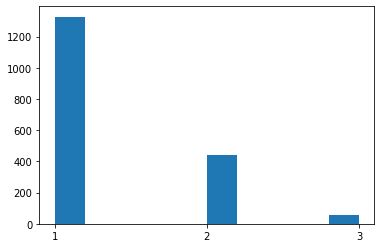

In [ ]:
plt.hist(label[label['disease']!='00']['risk'])

# 커스텀 데이터 셋 제작 

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,files,labels = None, mode='train'):
    self.mode = files
    self.csv_feature_dict = csv_feature_dict
    self.csv_feature_check = [0]*len(self.files)
    self.csv_features = [None]*len(self.files)
    self.max_len = -1*24*6
    self.label_encoder = label_encoder 
  
  def __len__(self):
    return len(self.files)

  def __getitem__(self,i):
    file = self.file[i]
    file_name = file.split('/')[-1]

    json_path = f'{file}/{file_name}.json'
    image_path = f'{file}/{file_name}.jpg'

    if self.csv_feature_check[i]==0:
      csv_path = f'{file}/{file_name}.csv'
      df = pd.read_csv(csv_path)

      # min max scaling
      for col in self.csv_fature_dict.keys():
        df[col] = df[col] - self.csv_feature_dict[col][0]
        df[col] = df[col]/(self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])

      # transpose to sequential data 
      csv_feature = df[self.csv_feature_dict.keys()].to_umpy()[self.max_len:].T
      self.csv_feature[i] = csv_feature
      self.csv_feature_check[i]= 1
    else:
      csv_feature = self.csv_features[i]
    
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(256,256),interpolation = cv2.INTER_AREA)
    img = cv2.astype(np.float32)/255 # 정규화 
    img = np.transpose(img,(2,0,1))

    if self.modes == 'train':
      with open(json_path,'r') as f:
        json_file = json.load(f)

      crop = json_file['annotations']['crop']
      disease = json_file['annotations']['disease']
      risk = json_file['annotations']['risk']
      label = f'{crop}_{disease}_{risk}'

      return {
          'img' : torch.tensor(img, dtype = torch.float32),
          'csv_feature': torch.tensor(csv_feature,dtype=float32)
          }

In [ ]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
def __init__(self, numbers, 

sequence_length=SEQUENCE_LENGTH, 

offset=OFFSET, 

batch_size=BATCH_SIZE, 

shuffle=True,

validation_split=0.0,

test_split=0.0,

indexes=None):

self.numbers = numbers

self.sequence_length = sequence_length

self.offset = offset

self.batch_size = batch_size

self.shuffle = shuffle

self.indexes, self.valid_indexes, self.test_indexes = self._prepare_indexes(validation_split, test_split, indexes)


def __len__(self):

return int(np.floor(len(self.indexes) / self.batch_size))


def __getitem__(self, index):

indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

return self._generate_data(indexes)


def on_epoch_end(self):

self._shuffle_index()


def _prepare_indexes(self, validation_split, test_split, indexes):

if indexes is not None:

return indexes, None, None


data_count = len(self.numbers) - (self.sequence_length+self.offset) + 1

all_index = np.arange(data_count)

np.random.shuffle(all_index)

if validation_split+test_split==0.0:

return all_index, None, None


valid_i = int(len(all_index)*(1-validation_split-test_split))

test_i = int(len(all_index)*(1-test_split))


return all_index[:valid_i], all_index[valid_i:test_i], all_index[test_i:]

def _shuffle_index(self):

if self.shuffle == True:

np.random.shuffle(self.indexes)


def _generate_data(self, indexes):

X = np.empty((len(indexes), self.sequence_length, self.numbers.shape[-1]))


# for i, index in enumerate(indexes): #<---------일반적인 경우 

# X[i] = self.numbers[index:index+self.sequence_length] 

# Y[i] = self.numbers[index+self.sequence_length+self.offset-1]

# return X, Y



Y = np.empty((len(indexes), self.numbers.shape[-1]))


for i, index in enumerate(indexes): #<------예측 문제의 경우 

if i+SEQUENCE_LENGTH+OFFSET >= len(indexes): break #<----마지막 순서가 되었을 때 iteration이 멈추도록 하는 장치

X[i] = self.numbers[i:i+SEQUENCE_LENGTH,:] 

Y[i] = self.numbers[i+SEQUENCE_LENGTH+OFFSET-1,:]

return X, Y


# Y = np.empty((len(indexes), 1))


# for i, index in enumerate(indexes): #<---------분류 문제의 경우 

# if i+SEQUENCE_LENGTH+OFFSET >= len(indexes): break #<----마지막 순서가 되었을 때 iteration이 멈추도록 하는 장치

# X[i] = self.numbers[i:i+SEQUENCE_LENGTH,:] 

# current_price = numbers[i+SEQUENCE_LENGTH-1,3] #<-------------이 부분부터 차이가 남 

# future_price = numbers[i+SEQUENCE_LENGTH+OFFSET,3]

# if future_price>current_price:

# Y[i]=1

# else:

# Y[i]=0

# # Y[i] = int(future_price > current_price)

# return X, Y

def get_all_data(self):

return self._generate_data(self.indexes) 


def subset(self, type):

if type=="train":

return DataGenerator(self.numbers, indexes=self.indexes)

elif type=="validation" or type=="valid":

return DataGenerator(self.numbers, indexes=self.valid_indexes)

elif type=="test":

return DataGenerator(self.numbers, indexes=self.test_indexes)

else:

print("invalid type {}".format(type))


# 제너레이터 분류 부분 -> y값이 0 또는 1로 되어야 하므로 Y가 바뀌어야 하는 거 아닌가? 그런데 바꾸려고 하니까 indexes 쪽에 문제가 생김, 알고보니 Y[i]를 넣을 때 5개를 넣었고 0과 1만 들어가게 바꿈

#그랬더니 이번엔 배치로 나올 때 0과1이 아닌 이상한 값들이 나옴



# 샘플 테스트 

In [8]:
temp_list = listdir[:50]

In [22]:
import cv2 
index = temp_list[0]
temp_img = cv2.imread(f'/content/train/{index}/{index}.jpg')

In [90]:
imgs = []
for index in temp_list:
  temp_img = cv2.imread(f'/content/train/{index}/{index}.jpg')
  temp_img = cv2.resize(temp_img,dsize = (224,224))
  imgs.append(temp_img)

In [91]:
imgs = np.array(imgs)

In [92]:
imgs.shape

(50, 224, 224, 3)

In [114]:
import pandas as pd 
df = pd.read_csv('/content/train.csv')

In [52]:
df.head()

,image,label
0,10027,3_b7_1
1,10037,3_00_0
2,10043,3_00_0
3,10045,3_00_0
4,10063,3_00_0


In [115]:
df['crop'] = df['label'].apply(lambda x:x[:1])

In [ ]:
temp_list = [int(x) for x in temp_list]

In [131]:
image_crop = []


for i in range(50): 
  image_crop.append(int(list(df[df['image'] == temp_list[i]]['crop'])[0]))

In [147]:
x = imgs 
y = np.array(image_crop)

(array([ 7.,  0.,  2.,  0., 21.,  0.,  9.,  0.,  3.,  8.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 10 Patch objects>)

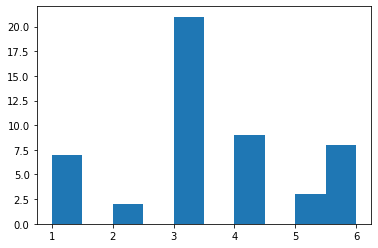

In [155]:
plt.hist(y)

In [156]:

for i in range(6):
  y[y==i+1]=i

(array([ 7.,  0.,  2.,  0., 21.,  0.,  9.,  0.,  3.,  8.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

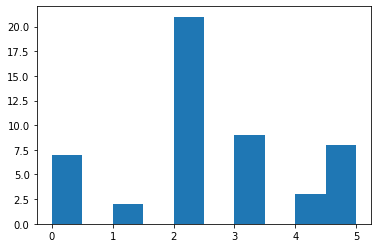

In [157]:
plt.hist(y)

In [158]:
from sklearn.model_selection import train_test_split
train_x,test_x, train_y,test_y = train_test_split(x,y,random_state=42)

In [160]:
import os


import matplotlib.pyplot as plt

import numpy as np


from tensorflow.keras import optimizers

from tensorflow.keras import models

from tensorflow.keras import layers

from tensorflow.keras import optimizers

from tensorflow.keras import Sequential

from tensorflow.keras.layers import Dropout, Flatten, Dense

from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.preprocessing.image import img_to_array


from tensorflow.keras.applications import vgg16,ResNet101V2

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet import preprocess_input


conv_layers = ResNet101V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

conv_layers.trainable = False

output = len(set(list(y.reshape(-1))))


model = models.Sequential()


model.add(conv_layers)

model.add(Flatten())

model.add(Dense(1024, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(output, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer="RMSprop", metrics=['acc'])



train_x = preprocess_input(train_x)

test_x = preprocess_input(test_x)



model.fit(train_x, train_y, epochs=10, batch_size=64, shuffle=True,validation_split = 0.1)



loss, acc = model.evaluate(test_x, test_y)

print("loss =",loss)

print("acc =",acc)


y_ = model.predict(test_x)

predicted = np.argmax(y_, axis=1)

print(predicted[0], custom_labels[predicted[0]])

171327488/171317808 [==============================] - 3s 0us/step
Epoch 1/10
1/1 [==============================] - 31s 31s/step - loss: 2987.2329 - acc: 0.2727 - val_loss: 332473.3750 - val_acc: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 457395.5312 - acc: 0.2424 - val_loss: 173057.2344 - val_acc: 0.7500
Epoch 3/10
1/1 [==============================] - 6s 6s/step - loss: 739765.1250 - acc: 0.4242 - val_loss: 104749.8516 - val_acc: 0.2500
Epoch 4/10
1/1 [==============================] - 6s 6s/step - loss: 296856.0625 - acc: 0.0606 - val_loss: 150322.2969 - val_acc: 0.7500
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 228728.6406 - acc: 0.4545 - val_loss: 236489.5469 - val_acc: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 6s 6s/step - loss: 186476.7656 - acc: 0.1515 - val_loss: 107519.4062 - val_acc: 0.7500
Epoch 7/10
1/1 [==============================] - 6s 6s/step - loss: 106549.4531 - acc: 0.3939 - val_lo

NameError: ignored